# Description

Notebook for custom sklearn wrappers for exclusion threshold classifier.

# Imports

In [3]:
%load_ext autoreload
%autoreload

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import sys
import warnings

from ipywidgets import interact_manual
from scipy.stats import norm
from scipy.special import logit
from sklearn.base import clone
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from linearmodels.iv import IV2SLS

# Common issue with glibc, scikit (?), where the number of libraries loaded with static TLS is limited
# Can only load one of econml or rpy2...
# e.g. https://github.com/pytorch/pytorch/issues/2575#issuecomment-523657178
from econml.dml import CausalForestDML, LinearDML
from econml.grf import CausalForest

# user imports
sys.path.append("../")

# Don't import iv_power for now since it needs rpy2
from utils.pwr import rdd_power
from utils.sim import generate_IV_comply_indicator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sandbox wrappers

- executive decision: probably easier to just write a custom fold validation
    - problem with using sklearn gridsearchCV: would be retraining the model on the same data for each threshold tested -> slowwww

In [4]:
def iv_neff(scores, tz_df, threshold):
    """
    Computes the effective sample size of the given data sample.
    
    Args:
        scores (np.array): array of compliance scores
        tz_df (pd.DataFrame)
    
    """    
    tz_df['score'] = scores
    sel_df = tz_df[tz_df['score'] >= threshold].copy()
    
    if (sel_df[(sel_df['Z'] == 1)].shape[0] == 0) or (sel_df[(sel_df['Z'] == 0)].shape[0] == 0):
        #print("no samples!")
        return -np.inf
    
    comply_rate = sel_df[(sel_df['Z'] == 1)]['T'].mean() - sel_df[(sel_df['Z'] == 0)]['T'].mean()
    
    return sel_df.shape[0] * (comply_rate**2)

In [5]:
class ThresholdCV():
    """
    Custom CV operation to detect the best threshold.
    
    Could also be converted to an estimator to be
    nested with GridSearchCV, down the line.
    """
    default_n_thresholds = 100
    random_state = 42
    
    def __init__(self, thresholds=None, n_splits=5, clf_class=None):
        self.thresholds = thresholds
        self.n_splits = n_splits
        
        if clf_class:
            self.clf_class = clf_class
        else:
            self.clf_class = CausalForest
        
    def get_best_threshold(self, iv_df, feat_cols):
        """
        Returns the best threshold based on KFold fitting.
        
        Args:
            iv_df (pd.DataFrame): the IV data
            feat_cols (list): the list of column name features
        """
        kfold = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        
        # each row is the neff score for all thresholds on a particular fold
        # each column holds all the fold scores for a particular threshold
        if self.thresholds is not None:
            neff_scores = np.zeros((self.n_splits, len(self.thresholds)))
        else:
            neff_scores = np.zeros((self.n_splits, self.default_n_thresholds))
        
        for split_idx, (train_idx, test_idx) in enumerate(kfold.split(iv_df)):
            # print(idx)
            # print(train_idx)
            # print(test_idx)
            train_df = iv_df.iloc[train_idx].copy()
            test_df = iv_df.iloc[test_idx].copy()
            
            # train a single classifier for a given split
            train_X = train_df[feat_cols]
            train_Y = train_df['T']
            train_T = train_df['Z']
            
            test_X = test_df[feat_cols]
            test_Y = test_df['T']
            test_T = test_df['Z']
            
            # initialize the class constructor
            clf = self.clf_class(random_state=self.random_state)
            clf.fit(X=train_X, y=train_Y, T=train_T)
            #print(clf)
            
            scores = clf.predict(test_X)
            tz_df = test_df[['T', 'Z']].copy()
            
            # go over all thresholds with fixed clf
            if self.thresholds is None:
                self.thresholds = np.linspace(np.min(scores), np.max(scores), 
                                              num=self.default_n_thresholds).flatten()
            
            #print(self.thresholds)
            
            for thres_idx, threshold in enumerate(self.thresholds):
                neff = iv_neff(scores, tz_df, threshold)
                neff_scores[split_idx, thres_idx] = neff
    
        mean_neff = np.mean(neff_scores, axis=0)
        best_threshold = self.thresholds[np.argmax(mean_neff)]
        
        assert mean_neff.shape[0] == len(thresholds)
        
        #print("Best neff: {:.3f}".format(np.max(mean_neff)))
        #print("Best threshold: {:.3f}".format(best_threshold))
        return best_threshold
                
    

## Make data: strong compliance

In [6]:
seed = 42
tau = 0.25
n_samples = 2000
n_feats = 5
regression_dict = dict(n_informative=5, noise=0, n_features=n_feats)

iv_df = generate_IV_comply_indicator(n_samples=n_samples, 
                                    tau=tau,
                                    prop_nt=0.30,
                                    prop_at=0.30,
                                    use_covars=True,
                                    regression_dict=regression_dict,
                                    seed=seed)

feat_cols = ['feat_{}'.format(i) for i in range(n_feats)]

In [7]:
n_splits = 2

kfold = KFold(n_splits=n_splits,
             shuffle=True, random_state=42)

indices = []

# TODO be careful on what to split on
for train_idx, test_idx in kfold.split(iv_df): #, y=iv_df['Z']
    indices.append(test_idx)
    

s1_df = iv_df.iloc[indices[0]].copy()
s2_df = iv_df.iloc[indices[1]].copy()

In [8]:
%%time

thresholds = np.linspace(0, 1, num=100)
threshold_clf = ThresholdCV()#thresholds=thresholds)
best_threshold = threshold_clf.get_best_threshold(s1_df, feat_cols)

CPU times: user 4.42 s, sys: 561 ms, total: 4.98 s
Wall time: 3.59 s


In [9]:
# sanity check: no exclusion
print("no exclusion, s2_df neff", iv_neff([1] * int(n_samples / 2), s2_df, 0))
#print(iv_neff([1] * n_samples, iv_df, 0))

no exclusion, s2_df neff 149.03165057466623


In [10]:
# sanity check, fit model
s1_X = s1_df[feat_cols]
s1_Y = s1_df['T'].values
s1_T = s1_df['Z'].values

s2_X = s2_df[feat_cols]
s2_Y = s2_df['T'].values
s2_T = s2_df['Z'].values

clf = CausalForest()
clf.fit(X=s1_X, y=s1_Y, T=s1_T)

s2_scores = clf.predict(s2_X)

print("exclusion, s2_df neff", iv_neff(s2_scores, s2_df, best_threshold))

exclusion, s2_df neff 320.45275966786295


## Make data: weak compliance

In [51]:
seed = 42
tau = 0.25
n_samples = 2000
n_feats = 5
regression_dict = dict(n_informative=5, noise=75, n_features=n_feats)

iv_df = generate_IV_comply_indicator(n_samples=n_samples, 
                                    tau=tau,
                                    prop_nt=0.30,
                                    prop_at=0.30,
                                    use_covars=True,
                                    regression_dict=regression_dict,
                                    seed=seed)

feat_cols = ['feat_{}'.format(i) for i in range(n_feats)]

In [52]:
n_splits = 2

kfold = KFold(n_splits=n_splits,
             shuffle=True, random_state=42)

indices = []

# TODO be careful on what to split on
for train_idx, test_idx in kfold.split(iv_df): #, y=iv_df['Z']
    indices.append(test_idx)
    

s1_df = iv_df.iloc[indices[0]].copy()
s2_df = iv_df.iloc[indices[1]].copy()

In [53]:
%%time

thresholds = np.linspace(0, 1, num=100)
threshold_clf = ThresholdCV()#thresholds=thresholds)
best_threshold = threshold_clf.get_best_threshold(s1_df, feat_cols)

CPU times: user 4.43 s, sys: 545 ms, total: 4.98 s
Wall time: 3.57 s


In [54]:
# sanity check: no exclusion
print("no exclusion, s2_df neff", iv_neff([1] * int(n_samples / 2), s2_df, 0))
#print(iv_neff([1] * n_samples, iv_df, 0))

no exclusion, s2_df neff 142.96687864597746


In [55]:
# sanity check, fit model
s1_X = s1_df[feat_cols]
s1_Y = s1_df['T'].values
s1_T = s1_df['Z'].values

s2_X = s2_df[feat_cols]
s2_Y = s2_df['T'].values
s2_T = s2_df['Z'].values

clf = CausalForest()
clf.fit(X=s1_X, y=s1_Y, T=s1_T)

s2_scores = clf.predict(s2_X)

print("exclusion, s2_df neff", iv_neff(s2_scores, s2_df, best_threshold))

exclusion, s2_df neff 151.99997501200036


## Make data: noise

In [16]:
seed = 42
tau = 0.25
n_samples = 2000
n_feats = 5
regression_dict = dict(n_informative=0, noise=100, n_features=n_feats)

iv_df = generate_IV_comply_indicator(n_samples=n_samples, 
                                    tau=tau,
                                    prop_nt=0.30,
                                    prop_at=0.30,
                                    use_covars=True,
                                    regression_dict=regression_dict,
                                    seed=seed)

feat_cols = ['feat_{}'.format(i) for i in range(n_feats)]

In [17]:
n_splits = 2

kfold = KFold(n_splits=n_splits,
             shuffle=True, random_state=42)

indices = []

# TODO be careful on what to split on
for train_idx, test_idx in kfold.split(iv_df): #, y=iv_df['Z']
    indices.append(test_idx)
    

s1_df = iv_df.iloc[indices[0]].copy()
s2_df = iv_df.iloc[indices[1]].copy()

In [18]:
%%time

thresholds = np.linspace(0, 1, num=100)
threshold_clf = ThresholdCV()#thresholds=thresholds)
best_threshold = threshold_clf.get_best_threshold(s1_df, feat_cols)

CPU times: user 4.55 s, sys: 538 ms, total: 5.09 s
Wall time: 3.78 s


In [19]:
# sanity check: no exclusion
print("no exclusion, s2_df neff", iv_neff([1] * int(n_samples / 2), s2_df, 0))
#print(iv_neff([1] * n_samples, iv_df, 0))

no exclusion, s2_df neff 190.58600096682724


In [20]:
# sanity check, fit model
s1_X = s1_df[feat_cols]
s1_Y = s1_df['T'].values
s1_T = s1_df['Z'].values

s2_X = s2_df[feat_cols]
s2_Y = s2_df['T'].values
s2_T = s2_df['Z'].values

clf = CausalForest()
clf.fit(X=s1_X, y=s1_Y, T=s1_T)

s2_scores = clf.predict(s2_X)

print("exclusion, s2_df neff", iv_neff(s2_scores, s2_df, best_threshold))

exclusion, s2_df neff 189.93180362278542


# Simulation

## Functions

In [21]:
def fit_predict_compliance(fit_df, pred_df, feat_cols, tau, seed=0, clf=None):
    """
    Fits a compliance model on fit_df and returns the predicted compliance scores, 
    as well as predicted threshold. Specifically uses the cross-folding neff heuristic.
    
    Args:
        fit_df (pd.DataFrame): the dataframe to fit on
        pred_df (pd.DataFrame): the dataframe to generate prediction
        feat_cols (list): the list of feature columns to consider
        tau (float): the target treatment effect
        clf (model): an EconML CATE classifier, defaults to CausalForestDML if None provided
    
    Returns:
        exclusion_threshold, acc, selected_df
    """
    
    
    fit_df = fit_df.copy()
    pred_df = pred_df.copy()
    
    X = fit_df[feat_cols]
    T = fit_df['Z']
    Y = fit_df['T']
    
    # fit on fit_df data
    if clf is None:
        clf = CausalForest(random_state=seed)
#         clf = CausalForestDML(discrete_treatment=True,
#                               cv=10, 
#                               random_state=seed)
    
    clf.fit(y=Y, # need to switch back to capital "Y" for DML estimator
            T=T,
            X=X)
    
    # predict on fit and pred_df data
    fit_df['pred_comply'] = clf.predict(X)
    pred_df['pred_comply'] = clf.predict(pred_df[feat_cols])
    #fit_df['pred_comply'] = clf.effect(X)
    #pred_df['pred_comply'] = clf.effect(pred_df[feat_cols])
    
    #acc = clf.score(X=pred_df[feat_cols], Y=pred_df['T'], T=pred_df['Z'])
    acc = np.nan
    
    
    
    # use neff cross-validated scoring target here
    threshold_clf = ThresholdCV()
    exclusion_threshold = threshold_clf.get_best_threshold(fit_df, feat_cols)
            
    sel_df = pred_df[pred_df['pred_comply'] > exclusion_threshold]

    return exclusion_threshold, acc, sel_df


def populate_iv_results(df_dict, formula, data_df, tau, data_sample, acc=np.nan, threshold=np.nan):
    """
    Runs the 2SLS estimator and populates result_dict.
    
    Args:
        df_dict (dict)
        formulat (str): the patsy regression formula to use
        data_df (pd.DataFrame): the dataframe to run over
        tau (float): target treatment effect for power calculations
        data_sample (str): the name of the data sample
        acc (float): the test accuracy of the prediction, if applicable
        threshold (float): the complier threshold cutoff, if applicable
    
    Returns:
        None, but mutates result_dict
    """
    print("data_df shape:{}".format(data_df.shape[0]))
    iv_model = IV2SLS.from_formula(formula, data_df)
    iv_results = iv_model.fit(cov_type='robust')
    df_dict['tau_hat_{}'.format(data_sample)].append(iv_results.params['T'])
    df_dict['std_err_{}'.format(data_sample)].append(iv_results.std_errors['T'])
    df_dict['pwr_{}'.format(data_sample)].append(rdd_power(tau,iv_results.std_errors['T']**2))
    df_dict['n_incl_{}'.format(data_sample)].append(data_df.shape[0])
    df_dict['test_acc_{}'.format(data_sample)].append(acc)
    df_dict['threshold_{}'.format(data_sample)].append(threshold)
    

def simulate_optimal_exclusion(n_trials, clf=None, **kwargs):
    """
    Simulates optimal exclusion procedure with K=2 cross-fitting/sample splitting.
    
    Args:
        n_trials (int): number of trials to run
        clf (econml.DML): the compliance estimator to use
        kwargs: keyword arguments for gen_iv_with_comply_status
    
    Returns:
        df: a DataFrame containing:
            - trial
            - treatment effect estimate, std error, calculated power for:
                - full data simple 2SLS
                - full data 2SLS with covariates
                - s1 exclusion estimates
                - s2 exclusion estimates
            - s1, s2 number of included samples
            - s1, s2 compliance "test set" prediction accuracy
    """    
    print("true treatment effect: {}".format(kwargs['tau']))
    # initialize data dictionary    
    data_samples = ['full_simple', 'full_covar', 's1_simple', 's2_simple', 's1_s2_simple']
    vals = ['tau_hat', 'std_err', 'pwr', 'n_incl', 'test_acc', 'threshold']
    df_dict = { val + "_" + data: [] for val in vals for data in data_samples}
    df_dict['trial'] = []
    
    simple_formula = 'Y ~ 1 + [T ~ Z]'
    
    for trial in range(n_trials):
        fuzzy_df = generate_IV_comply_indicator(seed=trial, **kwargs)
        feat_cols = fuzzy_df.columns[fuzzy_df.columns.str.startswith("feat")].tolist()
        extended_formula = 'Y ~ 1 + {} + [T ~ Z]'.format(' + '.join(feat_cols))

        # simple model with full data
        populate_iv_results(df_dict, simple_formula, fuzzy_df, kwargs['tau'], 'full_simple')

        # covariate model with full data
        populate_iv_results(df_dict, extended_formula, fuzzy_df, kwargs['tau'], 'full_covar')
        
        # split sample, TODO think about whether we need to stratified split on T
        np.random.seed(trial)
        
        kfold = StratifiedKFold(n_splits=2,
             shuffle=True, random_state=trial)

        indices = []

        for train_idx, test_idx in kfold.split(fuzzy_df, y=fuzzy_df['T']):
            indices.append(test_idx)
    

        fit_df = fuzzy_df.iloc[indices[0]].copy()
        s2_df = fuzzy_df.iloc[indices[1]].copy()

        # fit on first half
        s1_threshold, s1_acc, s1_sel_df = fit_predict_compliance(fit_df, s2_df, feat_cols, 
                                                                 seed=trial,
                                                                 tau=kwargs['tau'], clf=clf)

        populate_iv_results(df_dict, simple_formula, s1_sel_df, kwargs['tau'], 's1_simple',
                            threshold=s1_threshold, acc=s1_acc)

        # fit on second half
        s2_threshold, s2_acc, s2_sel_df = fit_predict_compliance(s2_df, fit_df, feat_cols, 
                                                                 seed=trial,
                                                                 tau=kwargs['tau'], clf=clf)

        populate_iv_results(df_dict, simple_formula, s2_sel_df, kwargs['tau'], 's2_simple',
                            threshold=s2_threshold, acc=s2_acc)

        
        # fit on union of excluded samples
        populate_iv_results(df_dict, simple_formula, s1_sel_df.append(s2_sel_df), kwargs['tau'], 's1_s2_simple')

        df_dict['trial'].append(trial)
        print("trial {}".format(trial))

    return pd.DataFrame.from_dict(df_dict)

In [22]:
def run_full_simulation(n_trials, prop_complys, sim_dict, out_name):
    """
    Runs end-to-end the simulation for Figure 3.
    """
    for prop_comply in prop_complys:
        # equal proportion of never takers and always takers
        p_at = (1 - prop_comply) / 2
        p_nt = (1 - prop_comply) / 2
        sim_dict['prop_at'] = p_at
        sim_dict['prop_nt'] = p_nt

        result_df = simulate_optimal_exclusion(n_trials, **sim_dict)

        result_df['data_driven_tau'] = (result_df['tau_hat_s1_simple'] + result_df['tau_hat_s2_simple']) / 2
        
        # from law of total variance
        result_df['data_driven_var'] = ((result_df['std_err_s1_simple'] ** 2) + (result_df['std_err_s2_simple'] ** 2) + \
                                     (result_df['tau_hat_s1_simple'] - result_df['data_driven_tau'])**2 + \
                                     (result_df['tau_hat_s2_simple'] - result_df['data_driven_tau'])**2) / 2

        result_df['data_driven_std'] = np.sqrt(result_df['data_driven_var'])


        result_df['data_driven_pwr'] = result_df['data_driven_var'].apply(lambda x: rdd_power(tau, var=x))
        result_df['data_driven_n_incl'] = result_df['n_incl_s1_simple'] + result_df['n_incl_s2_simple']

        # TODO fix hardcoding
        name = "../results/{}_p_comply_{}.df".format(out_name, prop_comply)
        result_df.to_pickle(name)

In [23]:
def plot_tau_pwr(data_name, tau, p_complys):
    # load data
    name_prefix = "../results/{}_p_comply".format(data_name) + "_{}.df"
    all_df = pd.DataFrame()
    x_var = 'Proportion compliers'

    for p_comply in p_complys:
        gap_df = pd.read_pickle(name_prefix.format(p_comply))
        gap_df[x_var] = p_comply
        
        all_df = all_df.append(gap_df)

    tau_hats = pd.melt(all_df, id_vars=[x_var], value_vars = ['tau_hat_full_simple', 'tau_hat_full_covar', 
                                                      'tau_hat_s1_s2_simple'])
    pwrs = pd.melt(all_df, id_vars=[x_var], value_vars = ['pwr_full_simple', 'pwr_full_covar', 
                                                  'pwr_s1_s2_simple'])
    std_errs = pd.melt(all_df, id_vars=[x_var], value_vars = ['std_err_full_simple', 'std_err_full_covar', 
                                                      'std_err_s1_s2_simple'])

    fig, (ax1, ax2) = plt.subplots(1,2, dpi=300, figsize=(12,6))
    # reproduces NACI paper figure
    #fig, (ax1, ax2) = plt.subplots(1,2, dpi=100, figsize=(10,6))

    sns.barplot(data=tau_hats, hue="variable", x=x_var, y="value", ax=ax1)
    ax1.axhline(y=tau, label="true treatment effect", ls='--', color="black", alpha=0.5)
    ax1.set_ylabel("est. treatment effect (95% CI)")
    ax1.set_ylim(0,0.5)


    handles, labels = ax1.get_legend_handles_labels()
    new_labels = ['true treatment effect', 'TSLS', 'TSLS with covariates', 'data-driven TSLS']
    #ax1.legend(handles, new_labels, bbox_to_anchor=(2.9,1))
    ax1.legend(handles, new_labels)
    #ax1.set_xlabel("Proportion compliers ")
    #ax1.set_title("Treatment effect estimates")
    # sns.barplot(data=std_errs, hue="variable", x='P(treat) jump', y="value", ax=ax2)
    # ax2.set_ylabel("standard errors")
    # ax2.get_legend().set_visible(False)

    sns.barplot(data=pwrs, hue="variable", x=x_var, y="value", ax=ax2)#, estimator=median)
    #ax2.set_title("Statistical power")
    ax2.set_ylabel("estimated power (95% CI)")
    ax2.get_legend().set_visible(False)
    #ax2.set_xlabel("Proportion compliers (95% CI)")

## simulations and plots

In [41]:
tau = 0.25
n_samples = 2000
n_trials = 10
prop_complys = [0.2, 0.4, 0.6]

### Strong compliance prediction simulation (replicate the original figure 3)

In [42]:
strong_sim_dict = dict(
        tau = tau, # true treatment effect
        n_samples = n_samples,
        use_covars = True,
        # tunes how much the covariates influence compliance
        regression_dict = dict(n_informative=5, 
                               noise=0, 
                               n_features=5)
)

strong_out_name = "strong_comply"

In [43]:
%%time

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    run_full_simulation(n_trials, prop_complys, 
                        strong_sim_dict, 
                        strong_out_name)

true treatment effect: 0.25
data_df shape:2000
data_df shape:2000
data_df shape:305
data_df shape:268
data_df shape:573
trial 0
data_df shape:2000
data_df shape:2000
data_df shape:227


KeyboardInterrupt: 

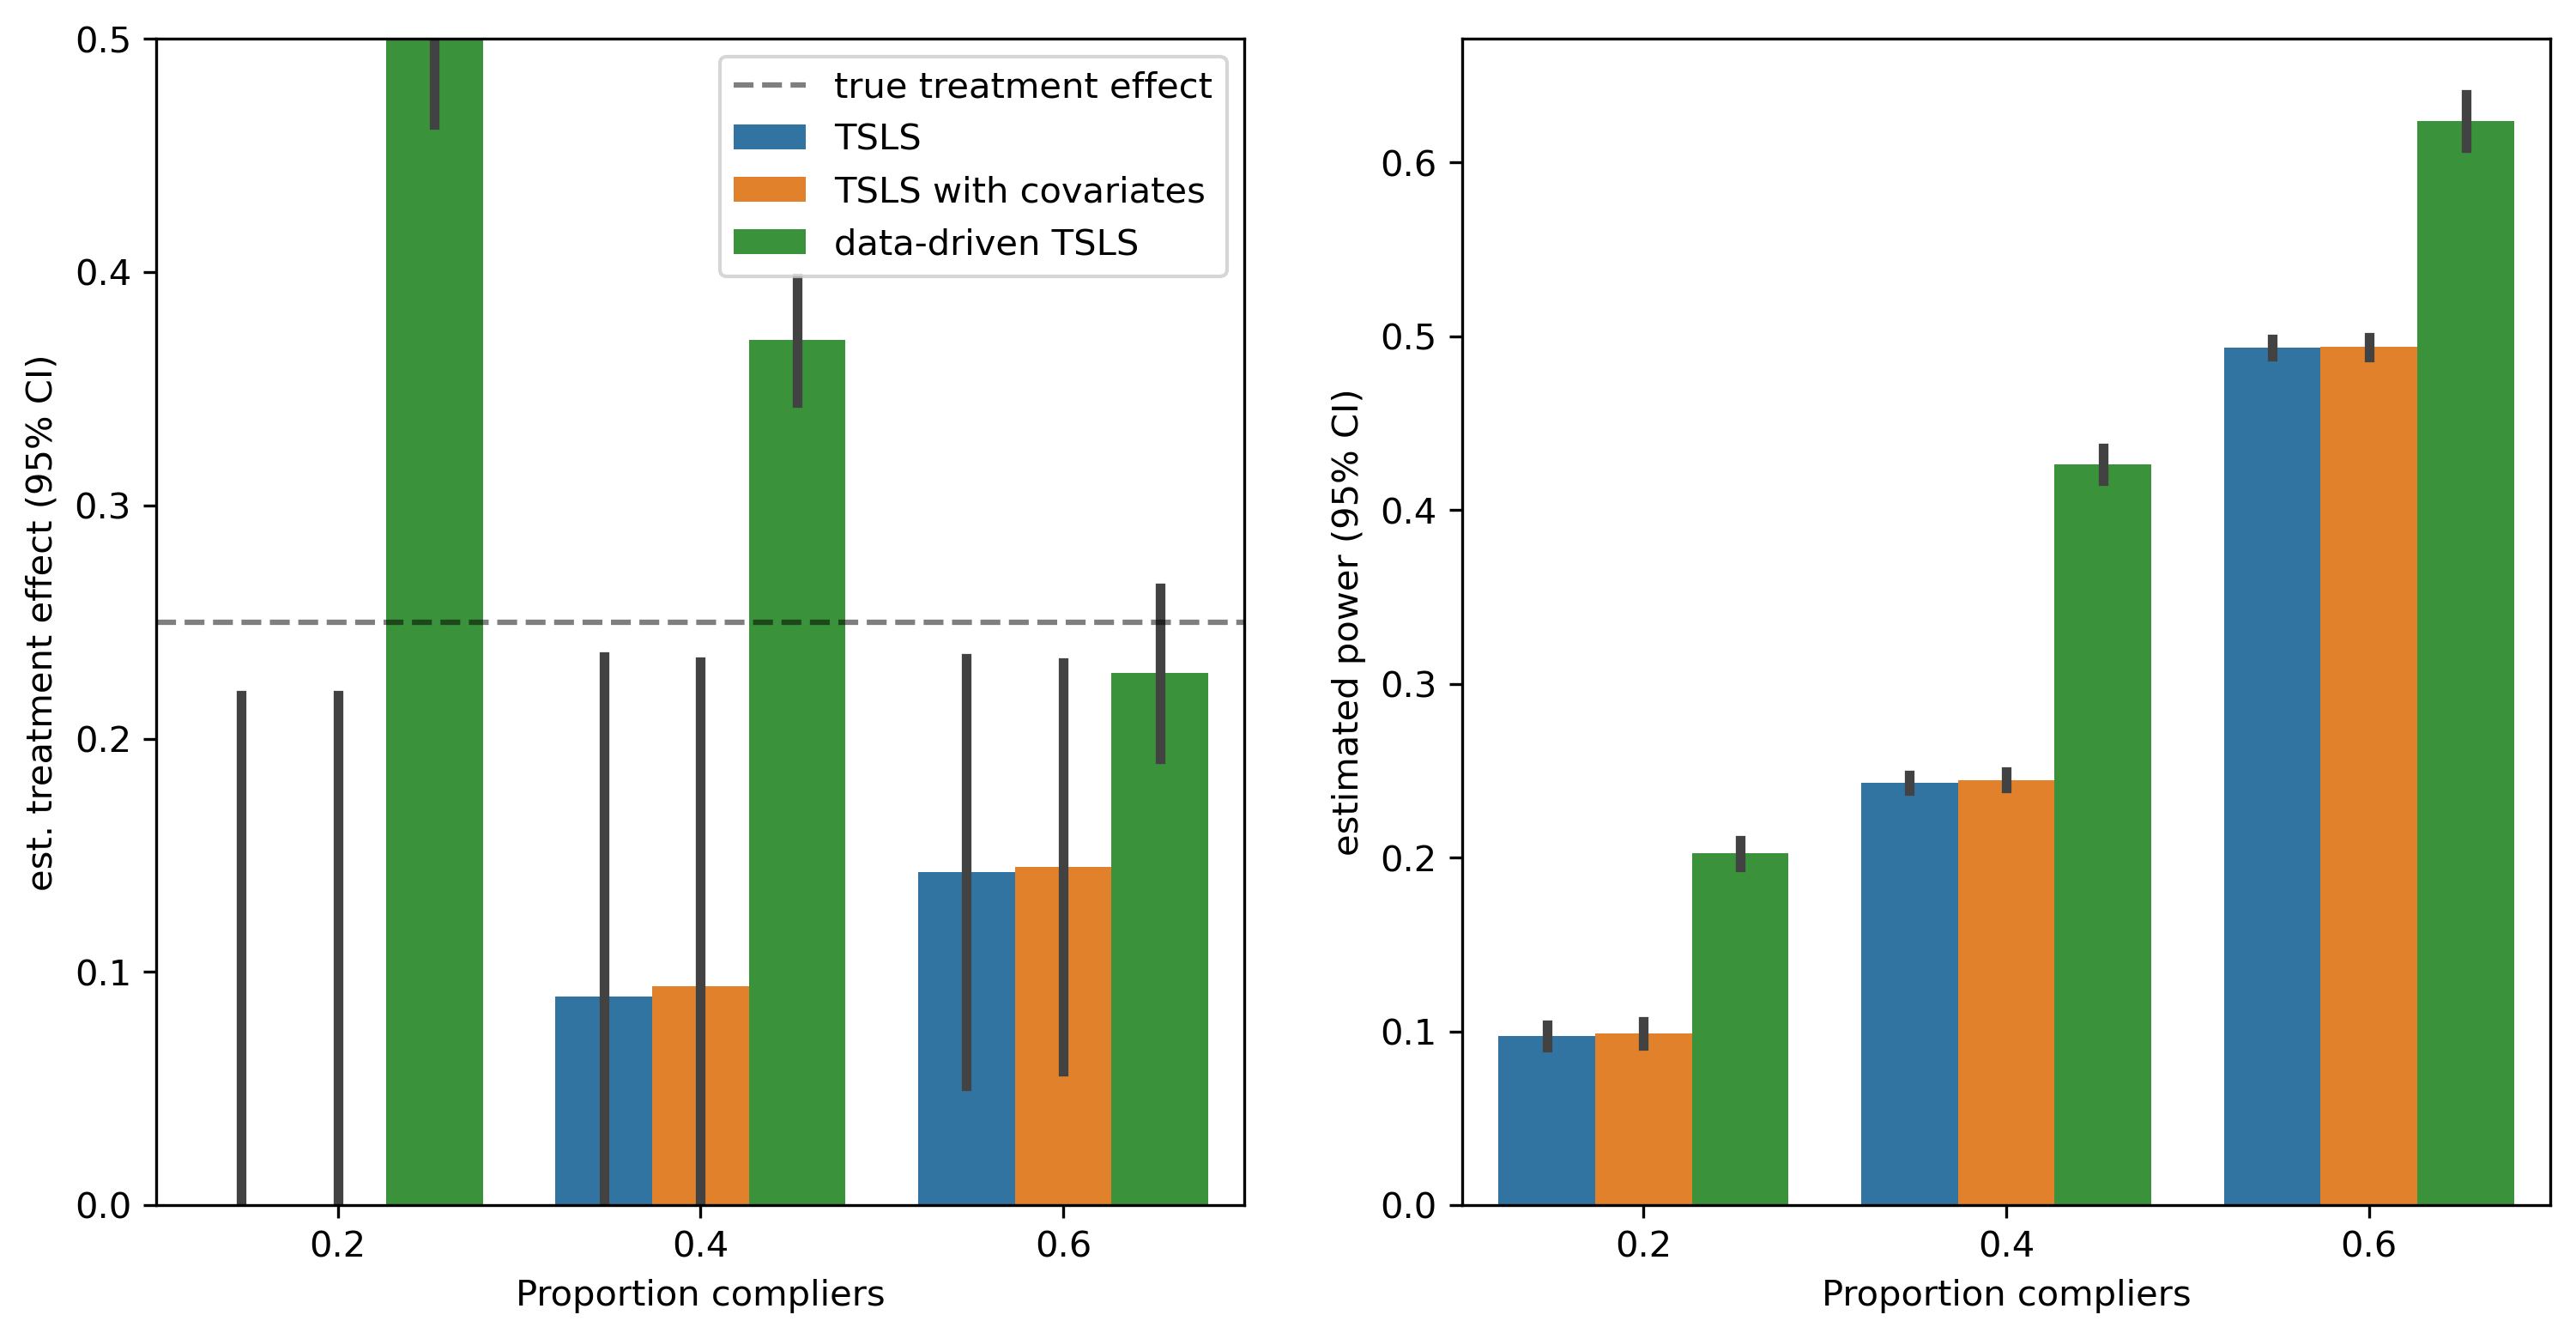

In [44]:
plot_tau_pwr(strong_out_name, tau, prop_complys)

### weak compliance prediction simulation

In [45]:
weak_sim_dict = dict(
        tau = tau, # true treatment effect
        n_samples = n_samples,
        use_covars = True,
        # tunes how much the covariates influence compliance
        regression_dict = dict(n_informative=5, 
                               noise=70, 
                               n_features=5)
)

weak_out_name = "weak_comply"

In [46]:
%%time

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    run_full_simulation(n_trials, prop_complys, 
                        weak_sim_dict, 
                        weak_out_name)

true treatment effect: 0.25
data_df shape:2000
data_df shape:2000


KeyboardInterrupt: 

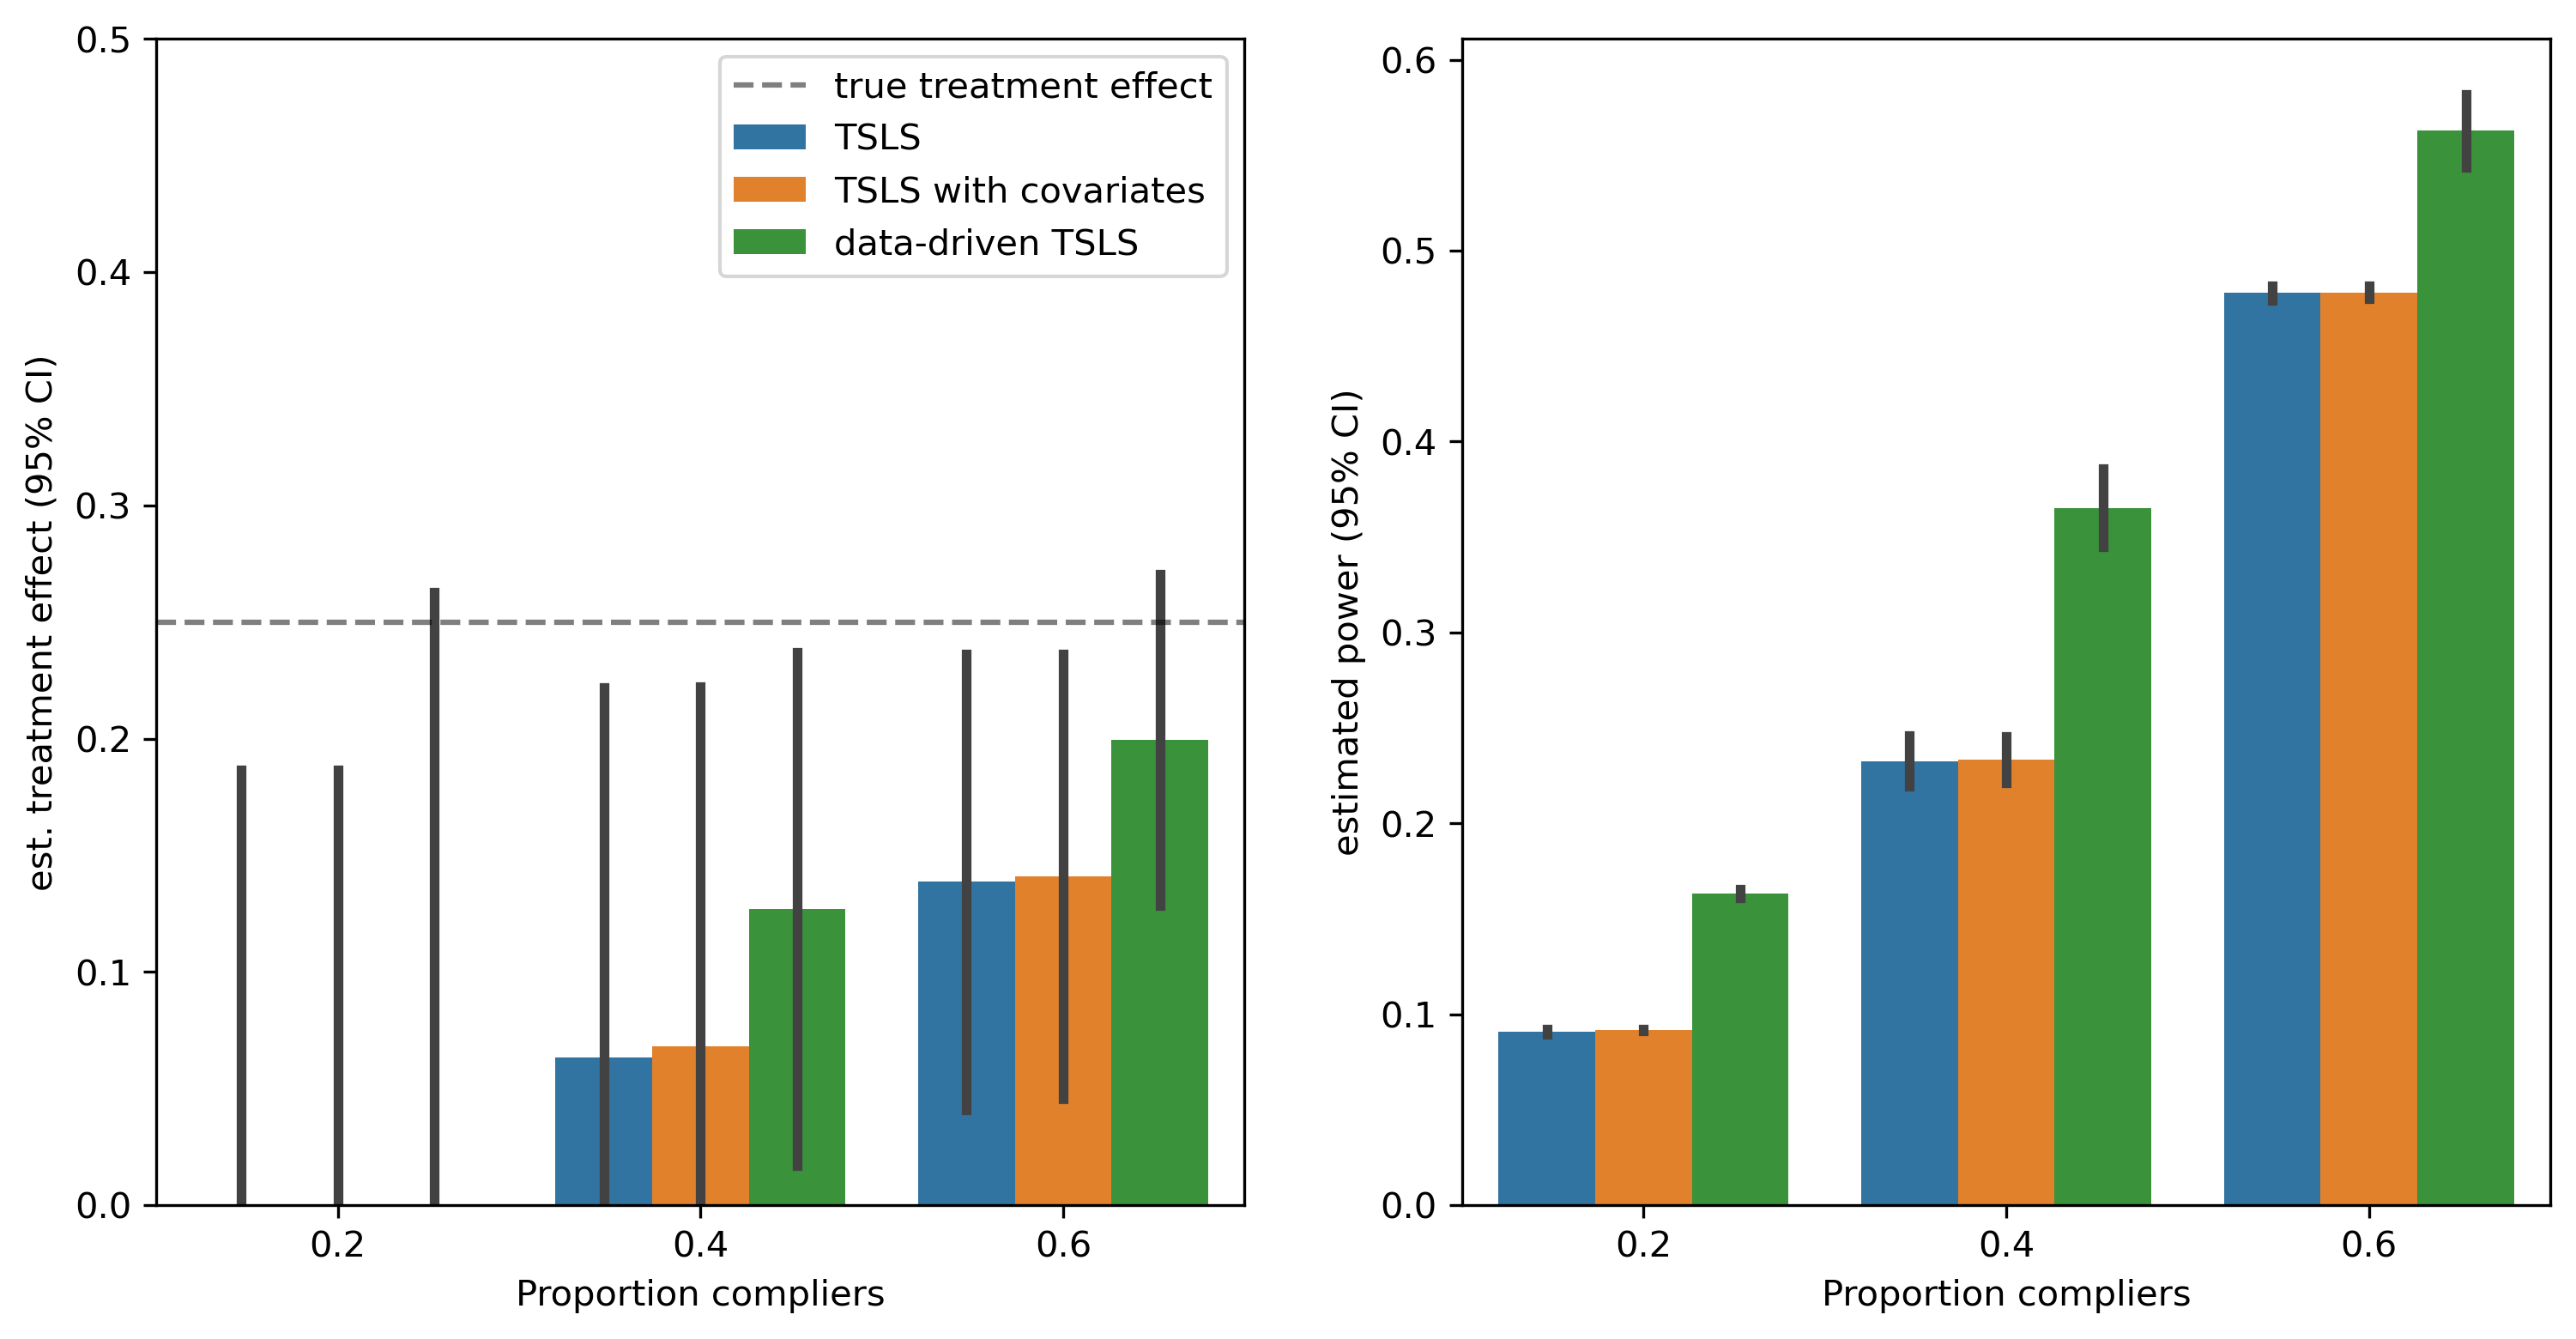

In [47]:
plot_tau_pwr(weak_out_name, tau, prop_complys)

### noise compliance prediction simulation

In [48]:
noise_sim_dict = dict(
        tau = tau, # true treatment effect
        n_samples = n_samples,
        use_covars = True,
        # tunes how much the covariates influence compliance
        regression_dict = dict(n_informative=0, 
                               noise=75, 
                               n_features=5)
)

noise_out_name = "noise_comply"

In [49]:
%%time

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    run_full_simulation(n_trials, prop_complys, 
                        noise_sim_dict, 
                        noise_out_name)

true treatment effect: 0.25
data_df shape:2000
data_df shape:2000
data_df shape:983
data_df shape:957
data_df shape:1940
trial 0
data_df shape:2000
data_df shape:2000
data_df shape:999
data_df shape:980
data_df shape:1979
trial 1
data_df shape:2000
data_df shape:2000
data_df shape:918
data_df shape:1000
data_df shape:1918
trial 2
data_df shape:2000
data_df shape:2000
data_df shape:941
data_df shape:921
data_df shape:1862
trial 3
data_df shape:2000
data_df shape:2000
data_df shape:974
data_df shape:990
data_df shape:1964
trial 4
data_df shape:2000
data_df shape:2000


KeyboardInterrupt: 

In [50]:
plot_tau_pwr(noise_out_name, tau, prop_complys)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fec11f76a70> (for post_execute):


KeyboardInterrupt: 

# Custom GridSearchCV sandbox

In [4]:
from sklearn.metrics import make_scorer

In [118]:
def iv_neff_score(y, y_pred, data=None):
    """
    Computes the effective sample size of the given data sample.
    
    Args:
        y (np.array): defined to match the function signature of a score, not used. 
        y_pred (np.array): binary indicator of whether a sample is included (1) or excluded (0)
        data (pd.DataFrame): the data frame containing T and Z
    
    """    
    data['sel'] = y_pred
    #print(data)
    sel_df = data[data['sel'] == 1].copy()
    
    comply_rate = sel_df[(sel_df['Z'] == 1)]['T'].mean() - sel_df[(sel_df['Z'] == 0)]['T'].mean()
    
    return sel_df.shape[0] * (comply_rate**2)

In [120]:
neff_scorer = make_scorer(iv_neff_score)

In [89]:
class ExcludeClassifier(CausalForest):
    """
    Wrapper class for CausalForest, with a threshold.
    
    TODO modify so that y actually contains both Z and T, which can then be passed into scorer as "y"
    "y_pred" should still be allowed as a single score.
    """
    def __init__(self, threshold=0.5, n_estimators=100):
        self.threshold = threshold
        super().__init__(n_estimators=n_estimators)
    
    def fit(self, X, y):
        """
        Here, to hack around the sklearn API, y is actually a df with 'T' and 'Z' values.
        """
        super().fit(X, T, y)
    
    def predict(self, X):
        preds = super().predict(X)
        
        return preds > self.threshold

In [53]:
n_splits = 2

kfold = KFold(n_splits=n_splits,
             shuffle=True, random_state=42)

indices = []

# TODO be careful on what to split on
for train_idx, test_idx in kfold.split(iv_df): #, y=iv_df['Z']
    indices.append(test_idx)
    

s1_df = iv_df.iloc[indices[0]].copy()
s2_df = iv_df.iloc[indices[1]].copy()

In [54]:

X = s1_df[feat_cols]
Y = s1_df['T'].values
T = s1_df['Z'].values

In [95]:
cforest = ExcludeClassifier()
cforest_cv = GridSearchCV(estimator=cforest,
                          param_grid={
                              "n_estimators": [100],
                              "threshold": [0.5, 0.7, 0.8]
                          },
                          scoring="accuracy", 
                          verbose=4)

In [96]:
%%time
cforest_cv.fit(X=X, y=Y, T=T)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...n_estimators=100, threshold=0.5;, score=0.570 total time=   0.4s
[CV 2/5] END ...n_estimators=100, threshold=0.5;, score=0.555 total time=   0.3s
[CV 3/5] END ...n_estimators=100, threshold=0.5;, score=0.565 total time=   0.3s
[CV 4/5] END ...n_estimators=100, threshold=0.5;, score=0.475 total time=   0.3s
[CV 5/5] END ...n_estimators=100, threshold=0.5;, score=0.570 total time=   0.3s
[CV 1/5] END ...n_estimators=100, threshold=0.7;, score=0.510 total time=   0.3s
[CV 2/5] END ...n_estimators=100, threshold=0.7;, score=0.485 total time=   0.3s
[CV 3/5] END ...n_estimators=100, threshold=0.7;, score=0.555 total time=   0.3s
[CV 4/5] END ...n_estimators=100, threshold=0.7;, score=0.455 total time=   0.3s
[CV 5/5] END ...n_estimators=100, threshold=0.7;, score=0.515 total time=   0.3s
[CV 1/5] END ...n_estimators=100, threshold=0.8;, score=0.500 total time=   0.3s
[CV 2/5] END ...n_estimators=100, threshold=0.8;,

GridSearchCV(estimator=ExcludeClassifier(),
             param_grid={'n_estimators': [100], 'threshold': [0.5, 0.7, 0.8]},
             scoring='accuracy', verbose=4)

In [97]:
cforest_cv.best_params_

{'n_estimators': 100, 'threshold': 0.5}